In [1]:
#%matplotlib
import numpy as np
pi = np.pi
import scipy.io as spio
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from qutip import *

from matplotlib import animation, rc
from IPython.display import HTML

mpl.rcParams['figure.dpi'] = 100

In [3]:
"\sigma^z_%d" % 1

'\\sigma^z_1'

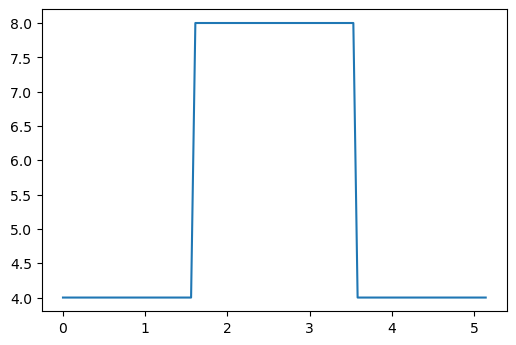

In [43]:
T_g = 2
b = .5 # buffer
L = np.pi/2 # gate time 
def G(t):    
    a = -4
    # Square pulse of length L and amplitude a centered at (b+L/2)
    A = -a*(np.heaviside(L - t, 0) + 2*(np.heaviside(t - L, 0) - np.heaviside(t - (T_g+L), 0)) + np.heaviside(t - (T_g+L), 0))
    return A

t_total = 2*L+T_g
tlist = np.linspace(0,t_total,100)
plt.plot(tlist,G(tlist))
plt.show()

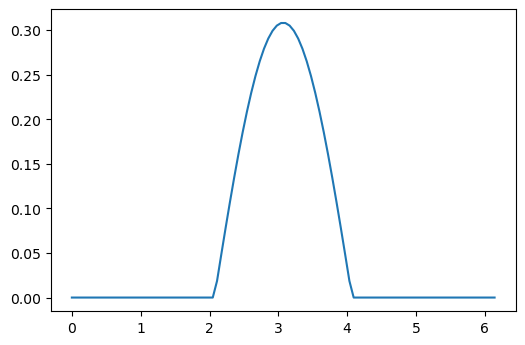

In [51]:
T_g = 2
b = .5 # buffer
L = np.pi/2 # gate time 

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    alpha = 2
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*(t-(L+b))/T_g)*(np.heaviside(t-(L+b),0)-np.heaviside(t-(T_g+L+b),0))

t_total = 2*b+2*L+T_g
tlist = np.linspace(0,t_total,100)
plt.plot(tlist,E(tlist,args={'phi':np.pi}))
plt.show()

In [19]:
num_lvl = 16 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G0 = 4
alpha = np.sqrt(G0) # amplitude
T_g = 2 # gate time of Rz
b = .5 # buffer
L = np.pi/2 # gate time H
t_total = 2*b+2*L+T_g

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()
# Sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def ry(theta):
    return (-1j*theta/2*sigma_y).expm()

# initial state
psi = up

# Time independent Hamiltonian
H0 = K * pow(a.dag(),2)*pow(a,2)

# Time depentent Hamiltonians
H1 = -(pow(a.dag(),2) + pow(a,2))
H2 = 1j*(a - a.dag())

# two photon pump amplitude
def G(t,args):
    # Square pulse of length L and amplitude a centered at (b+L/2)
    A = G0 * (np.heaviside(b - t,0) - np.heaviside(t - (L+b), 1) + np.heaviside(t - (T_g+L+b), 0) + np.heaviside(t - (T_g+2*L+b), 0))
    return A

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*(t-(L+b))/T_g)*(np.heaviside(t-(L+b),0)-np.heaviside(t-(T_g+L+b),0))

# total Hamiltonian
H = [H0,[H1,G],[H2,E]]

# time array
tlist = np.linspace(0,t_total,500)

opt = Options(nsteps=1e4)

# Master equation solver
angles = np.linspace(0,np.pi,20)
f = []
gamma = 1/1500
for angle in angles:
    rho = mesolve(H, psi, tlist, c_ops = [], e_ops = [], options = opt, args = {'phi': angle})
    rho_final = rho.states[-1]
    target_state = ry(angle) * psi
    f.append(fidelity(target_state,rho_final))
    
    
#print('fidelity',f)

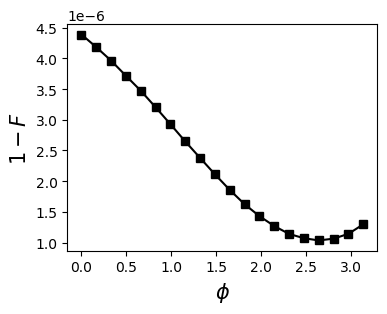

In [20]:
plt.figure(1,figsize=(4,3),dpi=100)
plt.plot(angles,(1-np.array(f)),'s-k')
plt.xlabel(r'$\phi$',fontsize=15);
plt.ylabel(r'$1-F$',fontsize=15);
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

## Wigner function

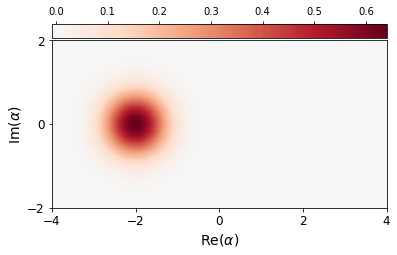

In [21]:
rho_final = (coherent(num_lvl,alpha) -1j* coherent(num_lvl,-alpha)).unit()

# Wigner function 
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(target_state,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')
#cbar.ax.xaxis.set_ticks_position('top')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

## Video

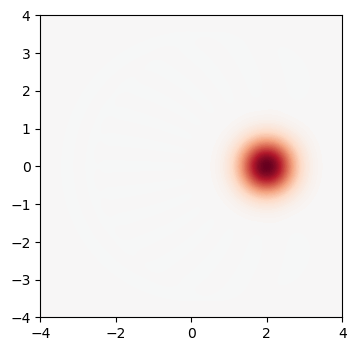

In [24]:
# Wigner function
xvec = np.linspace(-4,4,200)
yvec = np.linspace(-4,4,200)

fig, ax = plt.subplots()

ax.set_aspect('equal', adjustable='box')

ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))

ax.set_xlabel(r'Re$(\alpha)$', fontsize = 14)
ax.set_ylabel(r'Im$(\alpha)$', fontsize = 14)
ax.set_xticks(np.arange(min(xvec),max(xvec)+1,2))
ax.set_yticks(np.arange(min(yvec),max(yvec)+1,2))
ax.set_xticklabels(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
ax.set_yticklabels(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)
W = wigner(psi,xvec,yvec,'iterative',2)
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot

# initialization function: plot the background of each frame
def init():
    return cax

def animate(i):
    W = wigner(rho.states[i],xvec,yvec,'iterative',2)
    nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors
    ax.clear()
    ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
    return cax

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(rho.times)-1,6))

HTML(anim.to_html5_video())

In [5]:
num_lvl = 16 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G0 = 4
alpha = np.sqrt(G0) # amplitude
T_g = 2 # gate time of Rz
b = .5 # buffer
L = np.pi/2 # gate time H
t_total = 2*b+2*L+T_g

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# initial state
#psi = coherent(num_lvl,alpha)
#psi = (up+down).unit()
psi = (coherent(num_lvl,1j*alpha) + 1j*coherent(num_lvl,-1j*alpha)).unit()

# Time independent Hamiltonian
H0 = - K * pow(a.dag(),2)*pow(a,2) - G0*(pow(a.dag(),2) + pow(a,2))

# time array
tlist = np.linspace(0,t_total,500)

opt = Options(nsteps=1e4)

# Master equation solver
rho = mesolve(H0, psi, tlist, c_ops = [], e_ops = [], options = opt)
rho_final = rho.states[-1]

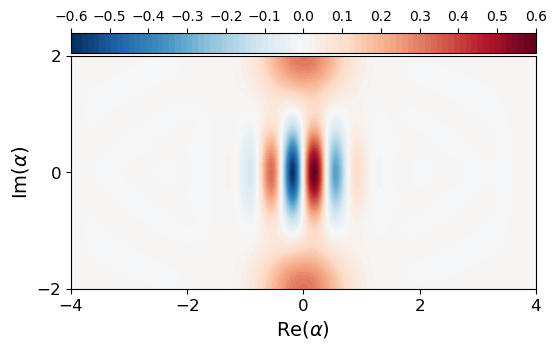

In [16]:
num_lvl = 16
alpha = 2
cat_p = (coherent(num_lvl,1j*alpha) + coherent(num_lvl,-1j*alpha)).unit()
cat_m = (coherent(num_lvl,-1j*alpha) - coherent(num_lvl,1j*alpha)).unit()
rho_final = (cat_p + 1j*cat_m)/np.sqrt(2)
#rho_final = (coherent(num_lvl,1j*alpha) + 1j* coherent(num_lvl,-1j*alpha)).unit()

# Wigner function 
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(rho_final,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')
#cbar.ax.xaxis.set_ticks_position('top')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

In [2]:
#%matplotlib
import numpy as np
pi = np.pi
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from qip.kpoprocessor import KPOProcessor
import scipy.io as spio

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

C:\Users\Wikstahl\Google Drive\PhD\Code\Python\Continuous Variable\qip\kpocompiler.py:177: DeprecationWarning: invalid escape sequence \s
  index = self.labels.index("\sigma^z_%d" % q)
C:\Users\Wikstahl\Google Drive\PhD\Code\Python\Continuous Variable\qip\kpocompiler.py:206: DeprecationWarning: invalid escape sequence \s
  index1 = self.labels.index(("\sigma^y_%d" % q))
C:\Users\Wikstahl\Google Drive\PhD\Code\Python\Continuous Variable\qip\kpocompiler.py:285: DeprecationWarning: invalid escape sequence \s
  index = self.labels.index("\sigma^x_%d" % q)
C:\Users\Wikstahl\Google Drive\PhD\Code\Python\Continuous Variable\qip\kpocompiler.py:315: DeprecationWarning: invalid escape sequence \s
  index = self.labels.index("\sigma^z_%d\sigma^z_%d" % (targets[0], targets[1]))


In [3]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

# Representation of a quantum program/algorithm, maintaining a sequence of gates.
N = 1
qc = QubitCircuit(N = N)
qc.add_state(state = "0", targets = range(N), state_type = "input")

qc.add_gate("RY", 0, None, np.pi/2)

In [4]:
kpo = KPOProcessor(N = N)
tlist, coeffs = kpo.load_circuit(qc)
print("Total time = %s (1/K)" % round(tlist[-1]))

Total time = 5.0 (1/K)


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x207935d1790>)

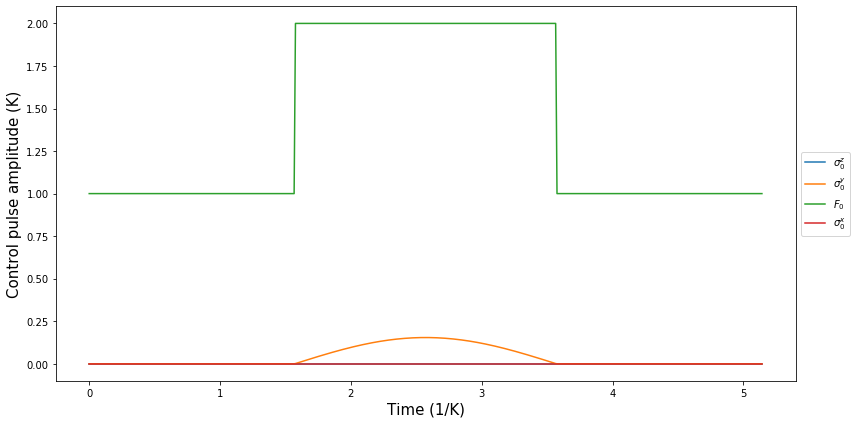

In [5]:
kpo.plot_pulses()

In [7]:
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']
eye = qeye(num_lvl)

# computational basis
up = coherent(num_lvl, alpha) # logical zero
down = coherent(num_lvl,-alpha) # logical one

# initial state
psi0 = up

# simulate
result = kpo.run_state(init_state = psi0, noisy = False)
final_state = result.states[-1]

In [8]:
# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()
# Sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def ry(theta):
    return (-1j*theta/2*sigma_y).expm()

target_state = ry(np.pi/2) * psi0
if final_state.type == 'ket':
    f = (target_state.dag() * final_state).full()[0][0]
    f = abs(f)**2
else:
    f = abs((target_state.dag() * final_state * target_state).full()[0][0])
print("Success Probability = %s %%" % round(f*100,3))

Success Probability = 99.982 %


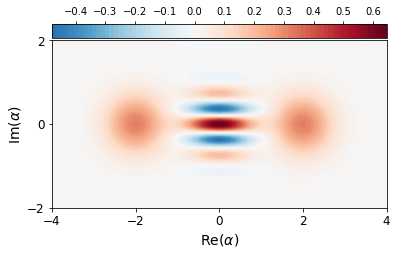

In [9]:
#rho_final = (coherent(num_lvl,1j*alpha) +1j* coherent(num_lvl,-1j*alpha)).unit()

# Wigner function 
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(final_state,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')
#cbar.ax.xaxis.set_ticks_position('top')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

# Test 2

In [44]:
num_lvl = 16 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G0 = 4
alpha = np.sqrt(G0) # amplitude
T_g = 2 # gate time of Rz
b = .5 # buffer
L = np.pi/2 # gate time H
t_total = 2*b+2*L+T_g

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()
# Sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def ry(theta):
    return (-1j*theta/2*sigma_y).expm()

# initial state
psi = up

# Time independent Hamiltonian
H0 = K * pow(a.dag(),2)*pow(a,2) - G0 * (a.dag()**2 + a**2)

# Time depentent Hamiltonians
H1 = - G0*(pow(a.dag(),2) + pow(a,2))
H2 = 1j*(a - a.dag())

# two photon pump amplitude
def G(t,args):
    # Square pulse of length L and amplitude a centered at (b+L/2)
    A = -1*(np.heaviside(L - t, 0) + 2*(np.heaviside(t - L, 0) - np.heaviside(t - (T_g+L), 0)) + np.heaviside(t - (T_g+L), 0))
    return A

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*(t-(L))/T_g)*(np.heaviside(t-(L),0)-np.heaviside(t-(T_g+L),0))

# total Hamiltonian
H = [H0,[H1,G],[H2,E]]

# time array
tlist = np.linspace(0,t_total,500)

opt = Options(nsteps=1e4)

# Master equation solver
angles = np.linspace(0,np.pi,20)
f = []
gamma = 1/250
for angle in angles:
    rho = mesolve(H, psi, tlist, c_ops = np.sqrt(gamma)*a, e_ops = [], options = opt, args = {'phi': angle})
    rho_final = rho.states[-1]
    target_state = ry(angle) * psi
    f.append(fidelity(target_state,rho_final))
    
    
#print('fidelity',f)

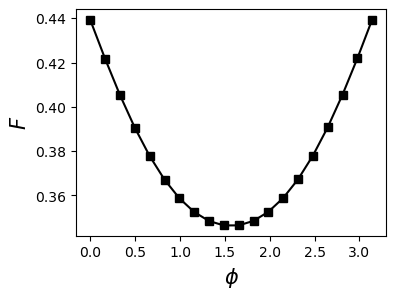

In [46]:
plt.figure(1,figsize=(4,3))
plt.plot(angles,np.array(f),'s-k')
plt.xlabel(r'$\phi$',fontsize=15);
plt.ylabel(r'$F$',fontsize=15);

## Test 3

In [1]:
num_lvl = 16 # number of levels
a = destroy(num_lvl) # annihilation operator
K = 1 # Kerr nonlinearity
G0 = 4
alpha = np.sqrt(G0) # amplitude
T_g = 2 # gate time of Rz
L = np.pi/2 # gate time H
t_total = 2*L+T_g

# computational basis
up = coherent(num_lvl,alpha)
down = coherent(num_lvl,-alpha)

# Sigma-x in computational basis
sigma_x = up*down.dag() + down*up.dag()
# Sigma-y in computational basis
sigma_y = 1j*(-up*down.dag() + down*up.dag())

def ry(theta):
    return (-1j*theta/2*sigma_y).expm()

# initial state
psi = (up + down).unit()

# Time independent Hamiltonian
H0 = K * pow(a.dag(),2)*pow(a,2) - G0 * (a.dag()**2 + a**2)

# Time depentent Hamiltonians
H1 = G0 * (a.dag()**2 + a**2)
H2 = 1j*(a - a.dag())

# two photon pump amplitude
def G(t,args):
    # Square pulse of length L and amplitude a centered at (b+L/2)
    A = (np.heaviside(L - t, 0) + 2*(np.heaviside(t - L, 0) - np.heaviside(t - (T_g+L), 0)) + np.heaviside(t - (T_g+L), 0))
    return A

# single photon pump amplitude
def E(t,args):
    phi = args['phi']
    return np.pi*phi/(8*T_g*alpha)*np.sin(np.pi*(t-(L))/T_g)*(np.heaviside(t-(L),0)-np.heaviside(t-(T_g+L),0))

# total Hamiltonian
H = [H0,[H1,G],[H2,E]]

# time array
tlist = np.linspace(0,t_total,500)

opt = Options(nsteps=1e4)

# Master equation solver
angle = np.pi/8
rho = mesolve(H, psi, tlist, c_ops = [], e_ops = [], options = opt, args = {'phi': angle})
rho_final = rho.states[-1]
target_state = ry(angle) * psi
f = fidelity(target_state,rho_final)
print('fidelity',f)

NameError: name 'destroy' is not defined

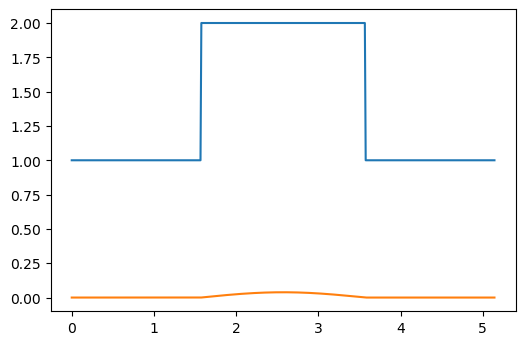

In [74]:
plt.plot(tlist,G(tlist,args={}))
plt.plot(tlist,E(tlist,args = {'phi': angle}))

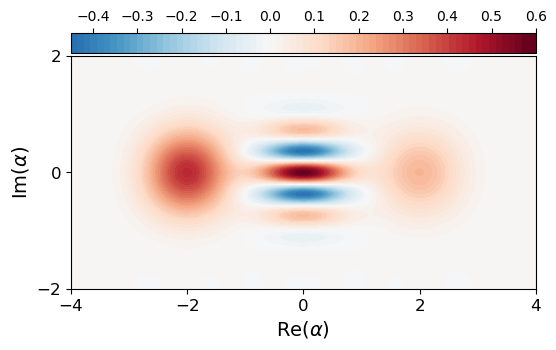

In [75]:
#rho_final = (coherent(num_lvl,1j*alpha) +1j* coherent(num_lvl,-1j*alpha)).unit()

# Wigner function 
xvec = np.linspace(-4,4,400)
yvec = np.linspace(-2,2,200)
W = wigner(rho_final,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# Plot
fig, ax = plt.subplots()
cax = ax.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm)
cbar = fig.colorbar(cax, ax = ax, orientation='vertical')
#cbar.ax.xaxis.set_ticks_position('top')

# contour plot
plt.subplot(111,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

# colorbar
cax = plt.axes([0.125, 0.8, 0.775, 0.05]) # left, bottom, width, height
plt.colorbar(im, cax = cax, orientation = 'horizontal', ticklocation = 'top', ticks = np.arange(round(W.min())-1,round(W.max()+.1)+.1,0.1));

In [45]:
num_lvl = 60
alpha = 0.1
cat_p = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_m = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

ket0 = (cat_p + cat_m)/np.sqrt(2)
ket1 = (cat_p - cat_m)/np.sqrt(2)

o = ket0.dag() * ket1
print(o)

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]


In [42]:
num_lvl = 60
alpha = .4
cat_p = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_m = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

ket0 = coherent(num_lvl,alpha)
ket1 = coherent(num_lvl,-alpha)

o = ket0.dag() * ket1
print(o)

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.72614904]]
